<a href="https://colab.research.google.com/github/Srihari293/Machine-Learning-Projects/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Food Vision App
This project attempts to create a food vision app using transfer learning and neural networks keeping the DeepFood101 paper as the benchmark.



### Housekeeping

In [3]:
# Housekeeping
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-44310e9d-a4fa-224f-43e9-7d488bd7fd48)


In [51]:
# Importing helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

import tensorflow as tf
import matplotlib.pyplot as plt 
import tensorflow_datasets as tfds
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

!sudo pip3 install keras
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

--2022-07-15 14:46:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-15 14:46:54 (73.3 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
# Writing new functions
# Pre-processing functions before passing into neural network
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

### Importing datasets

In [6]:
# List available datasets
datasets_list = tfds.list_builders() 
print("food101" in datasets_list) 

True


In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteOEHANK/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteOEHANK/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Getting to know the data

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 43
  Class name (str form): fried_calamari
        


In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

In [14]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

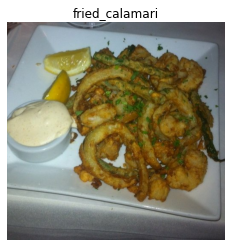

In [15]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.811226  54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


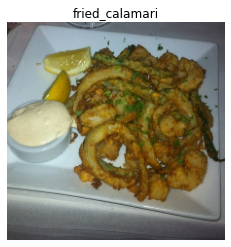

In [17]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Creating a data input pipe line


In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [20]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [21]:
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [22]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

### Base model - feature extraction model 

In [23]:
!sudo pip3 install keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
16719872/16705208 [==============================] - 0s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Checking layer dtype policies (are we using mixed precision?)


In [25]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [26]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

### Fit the model with callbacks

In [27]:
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220715-134819
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8241 - accuracy: 0.5564WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 194s 73ms/step - loss: 1.8241 - accuracy: 0.5564 - val_loss: 1.2289 - val_accuracy: 0.6735
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.6647WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 165s 69ms/step - loss: 1.2928 - accuracy: 0.6647 - val_loss: 1.1207 - val_accuracy: 0.6978
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1433 - accuracy: 0.7019WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 164s 69ms/step - loss: 1.1433 - accuracy: 0.7019 - val_loss: 1.0984 - val_accuracy: 0.7015


In [28]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 61s 77ms/step - loss: 1.0982 - accuracy: 0.7038


[1.0982359647750854, 0.7037623524665833]

In [29]:
# Clone the model we created (this resets all weights)
model_1 = tf.keras.models.clone_model(model)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [30]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [31]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [32]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [33]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [34]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 51s 62ms/step - loss: 1.0982 - accuracy: 0.7038


[1.0982348918914795, 0.7037623524665833]

In [35]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

In [36]:
# Preparing our model's layers for fine-tuning
loaded_gs_model = tf.keras.models.load_model(save_dir)

In [37]:
# Performance
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 51s 63ms/step - loss: 1.0982 - accuracy: 0.7038


[1.0982364416122437, 0.7037623524665833]

In [38]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [39]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

### Setting up early stopping

In [40]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [41]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [42]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [43]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=10, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220715-140216
Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 0.9219 - accuracy: 0.7525INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 392s 159ms/step - loss: 0.9219 - accuracy: 0.7525 - val_loss: 0.8304 - val_accuracy: 0.7659 - lr: 1.0000e-04
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.8399INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 373s 157ms/step - loss: 0.5765 - accuracy: 0.8399 - val_loss: 0.7747 - val_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 3/10
2368/2368 [==============================] - 330s 139ms/step - loss: 0.3321 - accuracy: 0.9056 - val_loss: 0.8717 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 4/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.1751 - accuracy: 0.9484
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 335s 141ms/step - loss: 0.1751 - accuracy: 0.9484 - val_loss: 0.9766 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 5/10
2368/2368 [==============================] - 332s 140ms/step - loss: 0.0363 - accuracy: 0.9915 - val_loss: 1.0473 - val_accuracy: 0.8003 - lr: 2.0000e-05


In [44]:
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


### Results:

In [45]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 51s 64ms/step - loss: 1.0424 - accuracy: 0.7970


[1.0424495935440063, 0.7969505190849304]

DeepFood's 77.4% top-1 accuracy versus our ~79% top-1 accuracy. We trained a computer vision model with competitive performance to a research paper and in less time (our model took ~20 minutes to train versus DeepFood's quoted 2-3 days).

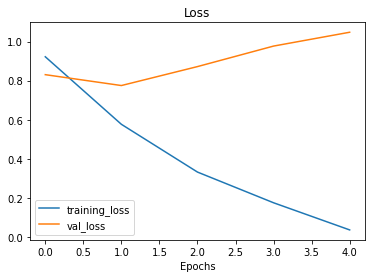

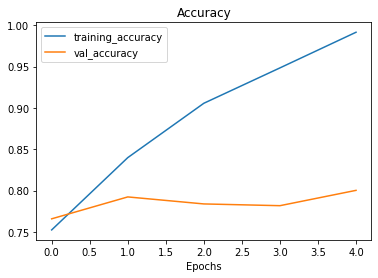

In [47]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

In [52]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip") 

--2022-07-15 14:47:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.45.16, 172.217.2.112, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.45.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-07-15 14:47:33 (118 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [54]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg']

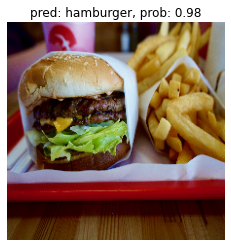

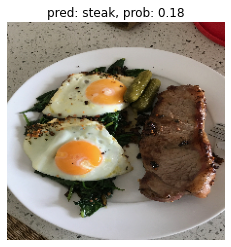

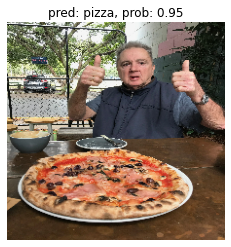

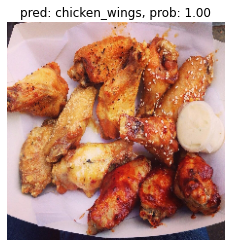

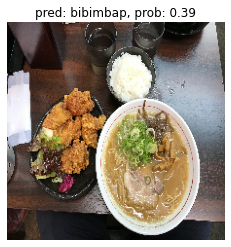

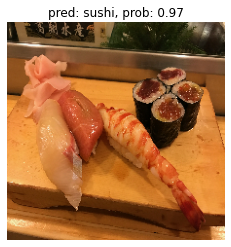

In [55]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)